# Project 2: Singapore Housing Data and Kaggle Challenge

### Introduction

Singapore's HDB resale market has been one of the largest source of property transactions in the last 3 decades. In an increasingly competitive market, access to information and the accuracy of information received is vital to sellers, buyers, and the brokers of such sales. First hand information on transactions are now publically available on the market and the moment you get your hands on it, chances are, all your competitors, be it sellers, buyers, or other real estate agents probably also have the same data that you have.

### Problem Statement

A team of realtors has engaged me to run this project for them in order to aid in their own presentations to prospective clients when projecting listings of their properties on online portals. They also want to use the model to help them better advise their clients who are buying on the prices that they should be expecting to pay. The model should be both complex enough for accuracy, yet simple enough to explain to people with varying degrees of knowledge on the subject matter.

### Importing and Cleaning of Data

In [1]:
# Import required libraries
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import pointbiserialr
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import category_encoders as ce

%matplotlib inline

In [2]:
# Importing train dataset
train_set = pd.read_csv('datasets/train.csv', low_memory = False)

In [3]:
# Standardising column naming convenion by replacing spaces with _
train_set.columns = [c.replace(' ', '_') for c in train_set.columns]

In [4]:
# Standardising column naming convenion by converting all to lower case
train_set.columns = train_set.columns.str.lower()

In [5]:
# Checking the shape of the dataset
train_set.shape

(150634, 78)

In [6]:
# Searching for null values
train_set.isnull().sum().sort_values(ascending = False).head(10)

hawker_within_500m         97390
mall_within_500m           92789
hawker_within_1km          60868
hawker_within_2km          29202
mall_within_1km            25426
mall_within_2km             1940
mall_nearest_distance        829
hawker_nearest_distance        0
mrt_nearest_distance           0
hawker_market_stalls           0
dtype: int64

In [7]:
# Dropping null values for "mall_nearest_distance". Small enough number of values compared to the entire train set.
train_set = train_set.dropna(subset = ['mall_nearest_distance'])

In [8]:
train_set.isnull().sum().sort_values(ascending = False).head(10)

hawker_within_500m         96682
mall_within_500m           91960
hawker_within_1km          60318
hawker_within_2km          28716
mall_within_1km            24597
mall_within_2km             1111
mrt_nearest_distance           0
hawker_market_stalls           0
hawker_food_stalls             0
hawker_nearest_distance        0
dtype: int64

In [9]:
# Checking the shape of the dataset after dropping null values
train_set.shape

(149805, 78)

In [10]:
# Fill all null values with 0 instead of dropping them entirely.
# Most of the categories can use 0 as a score.
# After eyeballing some of the columns, I suspect some of them will require the input of a numerical value later on.

train_set.fillna(0, inplace = True)

In [11]:
train_set.isnull().sum().sort_values(ascending = False).head(10)

id                         0
mall_within_2km            0
mrt_nearest_distance       0
hawker_market_stalls       0
hawker_food_stalls         0
hawker_within_2km          0
hawker_within_1km          0
hawker_within_500m         0
hawker_nearest_distance    0
mall_within_1km            0
dtype: int64

In [12]:
train_set.head()

,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,...,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,...,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,...,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


In [13]:
train_set.shape

(149805, 78)

In [14]:
train_set.describe()

,id,floor_area_sqm,lease_commence_date,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,mid,...,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
count,149805.000000,149805.000000,149805.000000,1.498050e+05,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,...,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000,149805.000000
mean,92877.061073,97.228022,1992.316638,4.486621e+05,2016.466513,6.586756,8.263609,7.226955,9.300264,8.263609,...,394.903494,55.308948,0.113187,1.366230,103.839040,507.628791,210.131070,0.031935,1.365954,103.839268
std,53640.649122,24.438881,12.040577,1.432125e+05,2.742246,3.339708,5.482182,5.489195,5.481607,5.482182,...,234.186949,17.883460,0.316822,0.042692,0.072641,308.752257,20.005265,0.175827,0.042622,0.072641
min,1.000000,31.000000,1966.000000,1.500000e+05,2012.000000,1.000000,2.000000,1.000000,3.000000,2.000000,...,45.668324,20.000000,0.000000,1.274962,103.687724,38.913475,188.000000,0.000000,1.276029,103.687207
25%,46253.000000,75.000000,1984.000000,3.460000e+05,2014.000000,4.000000,5.000000,4.000000,6.000000,5.000000,...,227.083163,44.000000,0.000000,1.337289,103.773754,289.176378,188.000000,0.000000,1.337545,103.776008
50%,92970.000000,95.000000,1990.000000,4.200000e+05,2017.000000,7.000000,8.000000,7.000000,9.000000,8.000000,...,348.724666,54.000000,0.000000,1.364639,103.844210,446.671027,208.000000,0.000000,1.364334,103.842719
75%,139211.000000,112.000000,2001.000000,5.200000e+05,2019.000000,9.000000,11.000000,10.000000,12.000000,11.000000,...,502.097957,67.000000,0.000000,1.393910,103.897865,642.519665,224.000000,0.000000,1.391781,103.899872
max,185966.000000,280.000000,2018.000000,1.258000e+06,2021.000000,12.000000,50.000000,49.000000,51.000000,50.000000,...,3305.841039,110.000000,1.000000,1.456667,103.962919,3638.977233,260.000000,1.000000,1.453280,103.961105


### EDA and Visualization

I will be starting this task by first dropping intuitively droppable features, then separating into categorical and continuous featues.

1. price_per_sqft - it is essentially a derivitive of our target predictions and may cause data leakage if included
2. all latitudes, longitudes and postal code - using these actual values to calculate exact distances may be too complex, other location features like town, planning area and address can be used.
3. street_name - already contained in address. 
4. tranc_yearmonth - we already have tranc_year, tranc_month.
5. lease_commence_date and year_completed - we already have the age of the flat which is a derivitive of this feature.
6. mid - same as mid_storey
7. town - overlaps with planning area
8. flat_type - over laps with full_flat_type

In [15]:
# Printing the columns and their data types so that I can look for any other item to clean up, specifically, columns with objects.
train_set.columns.to_series().groupby(train_set.dtypes).groups

{int64: ['id', 'lease_commence_date', 'tranc_year', 'tranc_month', 'mid_storey', 'lower', 'upper', 'mid', 'hdb_age', 'max_floor_lvl', 'year_completed', 'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental', 'other_room_rental', 'hawker_food_stalls', 'hawker_market_stalls', 'bus_interchange', 'mrt_interchange', 'vacancy', 'pri_sch_affiliation', 'cutoff_point', 'affiliation'], float64: ['floor_area_sqm', 'resale_price', 'floor_area_sqft', 'price_per_sqft', 'latitude', 'longitude', 'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km', 'mrt_nearest_distance', 'mrt_latitude', 'mrt_longitude', 'bus_stop_nearest_distance', 'bus_stop_latitude', 'bus_stop_longitude', 'pri_sch_nearest_distance', 'pri_sch_latitude', 'pri_sch_longitude', 's

In [16]:
# Dropping initial intuitively droppable features
train_set1 = train_set.drop(['price_per_sqft',
                            'latitude', 'longitude', 'mrt_latitude',
                            'mrt_longitude', 'sec_sch_latitude', 
                            'flat_type', 'block', 'street_name', 
                            'postal', 'town', 'bus_stop_name', 'tranc_yearmonth',
                            'mrt_name', 'pri_sch_latitude',
                            'pri_sch_longitude', 'sec_sch_longitude', 'mid',
                            'floor_area_sqft', 'bus_stop_latitude', 'bus_stop_longitude',
                            'year_completed', 'lease_commence_date'], axis = 1)

In [17]:
# Separate categorical features
cat_features = train_set1.select_dtypes(include=['object'])

In [18]:
# Add in resale price in categorical features
cat_features["resale_price"] = train_set1["resale_price"]

In [19]:
# Add om ID
cat_features['id'] = train_set1['id']

In [20]:
# Check cat_features shape
cat_features.shape

(149805, 14)

In [21]:
# Check all columns of cat_features
cat_features.columns.to_series().groupby(cat_features.dtypes).groups

{int64: ['id'], float64: ['resale_price'], object: ['storey_range', 'flat_model', 'full_flat_type', 'address', 'residential', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion', 'planning_area', 'pri_sch_name', 'sec_sch_name']}

In [22]:
# Check the first 5 rows of cat_features
cat_features.head()

,storey_range,flat_model,full_flat_type,address,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,planning_area,pri_sch_name,sec_sch_name,resale_price,id
0,10 TO 12,Model A,4 ROOM Model A,"3B, UPP BOON KENG RD",Y,N,N,N,N,Kallang,Geylang Methodist School,Geylang Methodist School,680000.0,88471
1,07 TO 09,Improved,5 ROOM Improved,"153, BISHAN ST 13",Y,N,N,N,N,Bishan,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian Secondary School,665000.0,122598
2,13 TO 15,Apartment,EXECUTIVE Apartment,"289B, BT BATOK ST 25",Y,N,N,N,N,Bukit Batok,Keming Primary School,Yusof Ishak Secondary School,838000.0,170897
3,01 TO 05,Model A,4 ROOM Model A,"232, BISHAN ST 22",Y,Y,N,N,N,Bishan,Catholic High School,Catholic High School,550000.0,86070
4,01 TO 03,Simplified,4 ROOM Simplified,"876, YISHUN ST 81",Y,N,N,N,N,Yishun,Naval Base Primary School,Orchid Park Secondary School,298000.0,153632


In [23]:
# Separate continuous features
cont_features = train_set1.select_dtypes(include=['int', 'float'])

In [24]:
# Check cont_features columns
cont_features.columns.to_series().groupby(cont_features.dtypes).groups

{int64: ['id', 'tranc_year', 'tranc_month', 'mid_storey', 'lower', 'upper', 'hdb_age', 'max_floor_lvl', 'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental', 'other_room_rental', 'hawker_food_stalls', 'hawker_market_stalls', 'bus_interchange', 'mrt_interchange', 'vacancy', 'pri_sch_affiliation', 'cutoff_point', 'affiliation'], float64: ['floor_area_sqm', 'resale_price', 'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km', 'mrt_nearest_distance', 'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'sec_sch_nearest_dist']}

In [25]:
# Check cont_features shape
cont_features.shape

(149805, 43)

In [26]:
# Check first 5 rows of cont_features
cont_features.head()

,id,floor_area_sqm,resale_price,tranc_year,tranc_month,mid_storey,lower,upper,hdb_age,max_floor_lvl,...,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,88471,90.0,680000.0,2016,5,11,10,12,15,25,...,330.083069,0,0,29.427395,1138.633422,78,1,1138.633422,224,0
1,122598,130.0,665000.0,2012,7,8,7,9,34,9,...,903.659703,1,1,58.207761,415.607357,45,1,447.894399,232,0
2,170897,144.0,838000.0,2013,7,14,13,15,24,16,...,1334.251197,1,0,214.747860,498.849039,39,0,180.074558,188,0
3,86070,103.0,550000.0,2012,4,3,1,5,29,11,...,907.453484,1,1,43.396521,389.515528,20,1,389.515528,253,1
4,153632,83.0,298000.0,2017,12,2,1,3,34,4,...,412.343032,0,0,129.422752,401.200584,74,0,312.025435,208,0


I will then work on the continuous features first to determine correlation.

In [27]:
# Check correlation
cont_features.corr()['resale_price'].sort_values(ascending = True)

3room_sold                  -0.411948
hdb_age                     -0.348430
2room_sold                  -0.146455
total_dwelling_units        -0.144782
mrt_nearest_distance        -0.127939
mall_nearest_distance       -0.087096
3room_rental                -0.080059
2room_rental                -0.077612
1room_sold                  -0.039488
1room_rental                -0.037992
hawker_food_stalls          -0.032899
tranc_year                  -0.024679
vacancy                     -0.017042
hawker_nearest_distance     -0.016078
pri_sch_nearest_distance    -0.010871
hawker_market_stalls        -0.008555
tranc_month                 -0.005685
affiliation                 -0.000645
bus_interchange              0.003277
hawker_within_500m           0.013037
other_room_rental            0.013143
bus_stop_nearest_distance    0.030546
pri_sch_affiliation          0.031328
cutoff_point                 0.036112
multigen_sold                0.037608
studio_apartment_sold        0.041589
mrt_intercha

Text(0.5, 1.0, 'Correlation with Resale Price')

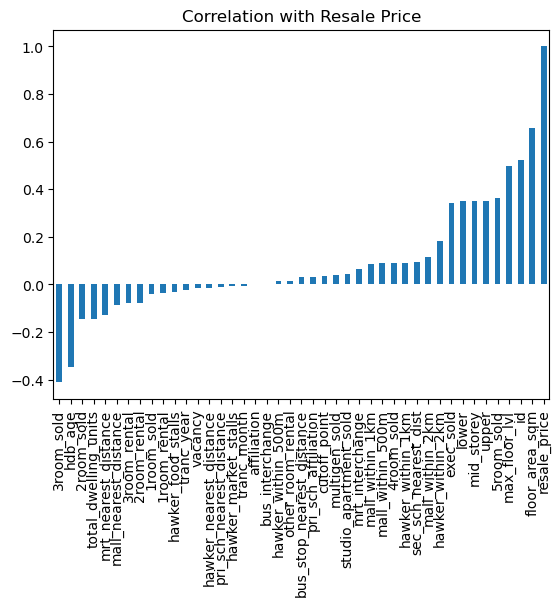

In [28]:
# Visualize correlation 
cont_features.corr()['resale_price'].sort_values(ascending = True).plot(kind ='bar')

plt.title('Correlation with Resale Price')

I then pick the top 10 correlated features for my model
1. floor_area_sqm
2. max_floor_lvl
3. 5room_sold
4. upper
5. exec_sold
6. hawker_within_2km
7. 3room_sold
8. hdb_age
9. 2room_sold
10. total_dwelling_units

In [29]:
# Getting the mean of resale_price
resale_mean = np.mean(cont_features["resale_price"])
resale_mean

448662.0642550647

I will now use scatter plots of resale price against the 10 features with the mean to help determine my selected features by observing patterns and also check for outliers that may be affecting the correlation.

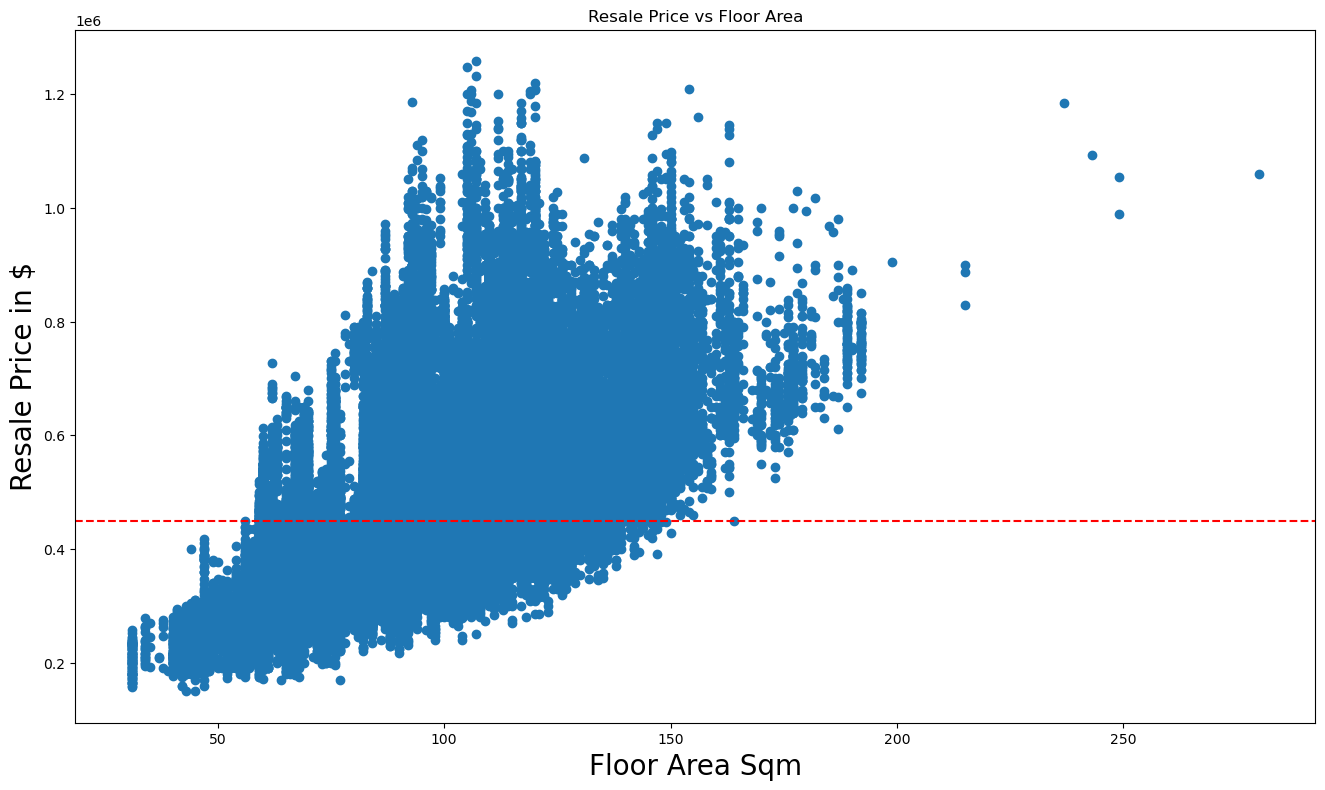

In [30]:
# Plot scatter plot of resale price vs floor area in sqm
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['floor_area_sqm'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs Floor Area")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("Floor Area Sqm", fontsize = 20);

There is a positive correlationship between floor area and the resale price. Most of the smaller units under 100 sqm have prices that fall below the mean whilst larger units generally command prices higher than the mean.

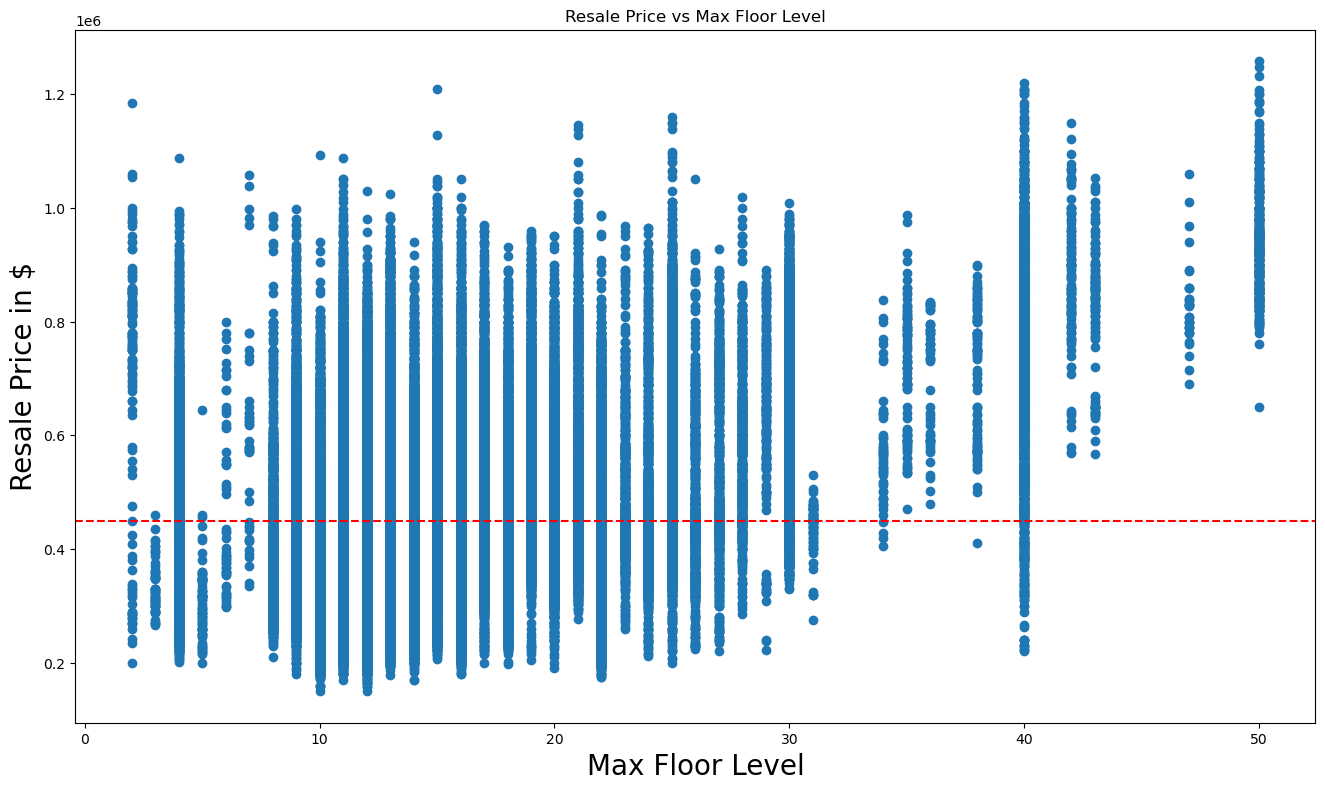

In [31]:
# Plot scatter plot of resale price vs max floor level
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['max_floor_lvl'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs Max Floor Level")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("Max Floor Level", fontsize = 20);

Max floor level, although not as obvious as floor area also has a similar pattern. Blocks with higher floors tend to have prices higher than the mean, especially above 30 floors.

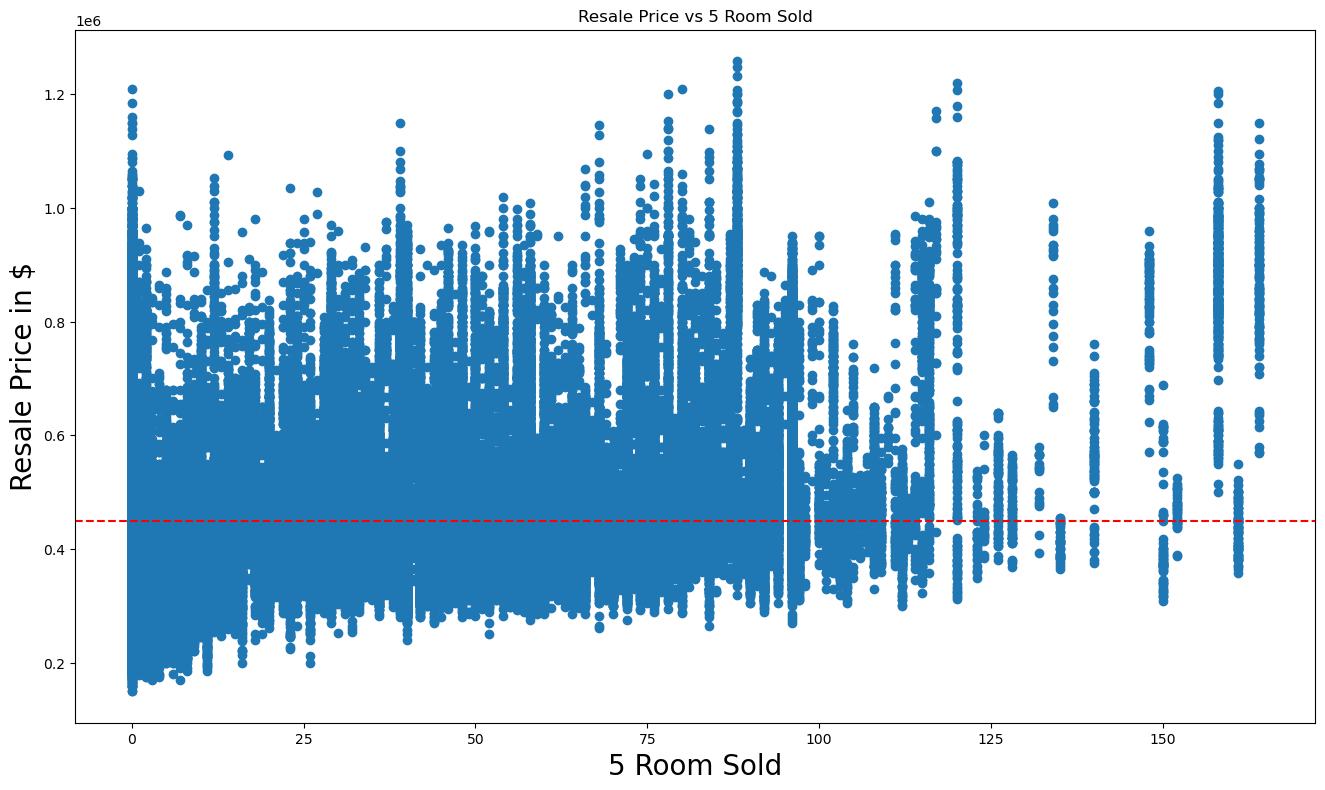

In [32]:
# Plot scatter plot of resale price vs 5 room sold
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['5room_sold'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs 5 Room Sold")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("5 Room Sold", fontsize = 20);

For 5 room units sold, it can be observed that blocks with a higher of 5 rooms sold, tend to have a higher value count of units that have resale values above the mean, although there are some blocks that also have higher counts above the mean with very few 5 room units sold.

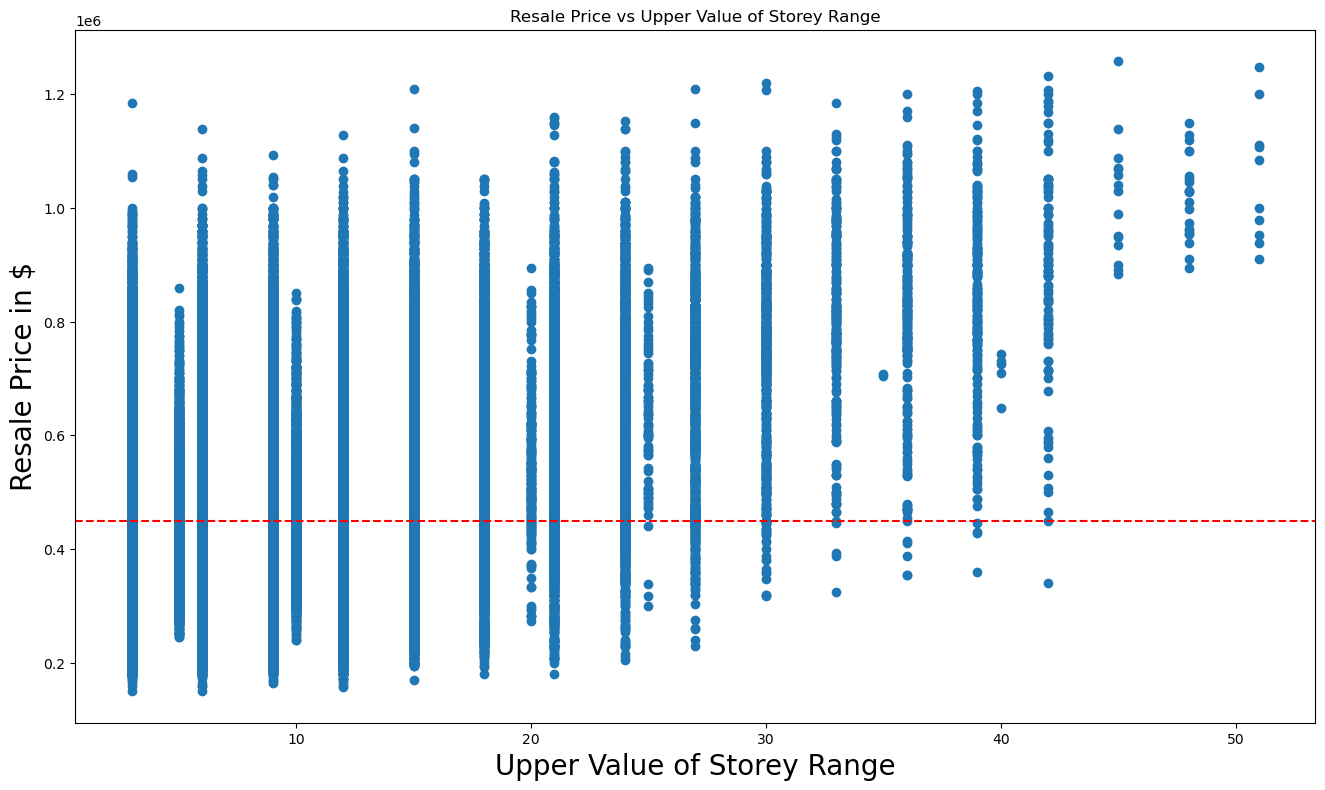

In [33]:
# Plot scatter plot of resale price vs upper value of storey range
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['upper'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs Upper Value of Storey Range")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("Upper Value of Storey Range", fontsize = 20);

This category seems similar to the max level of the block. The higher the upper value of storey range, the higher the proportion of units sold for prices above the mean resale value.

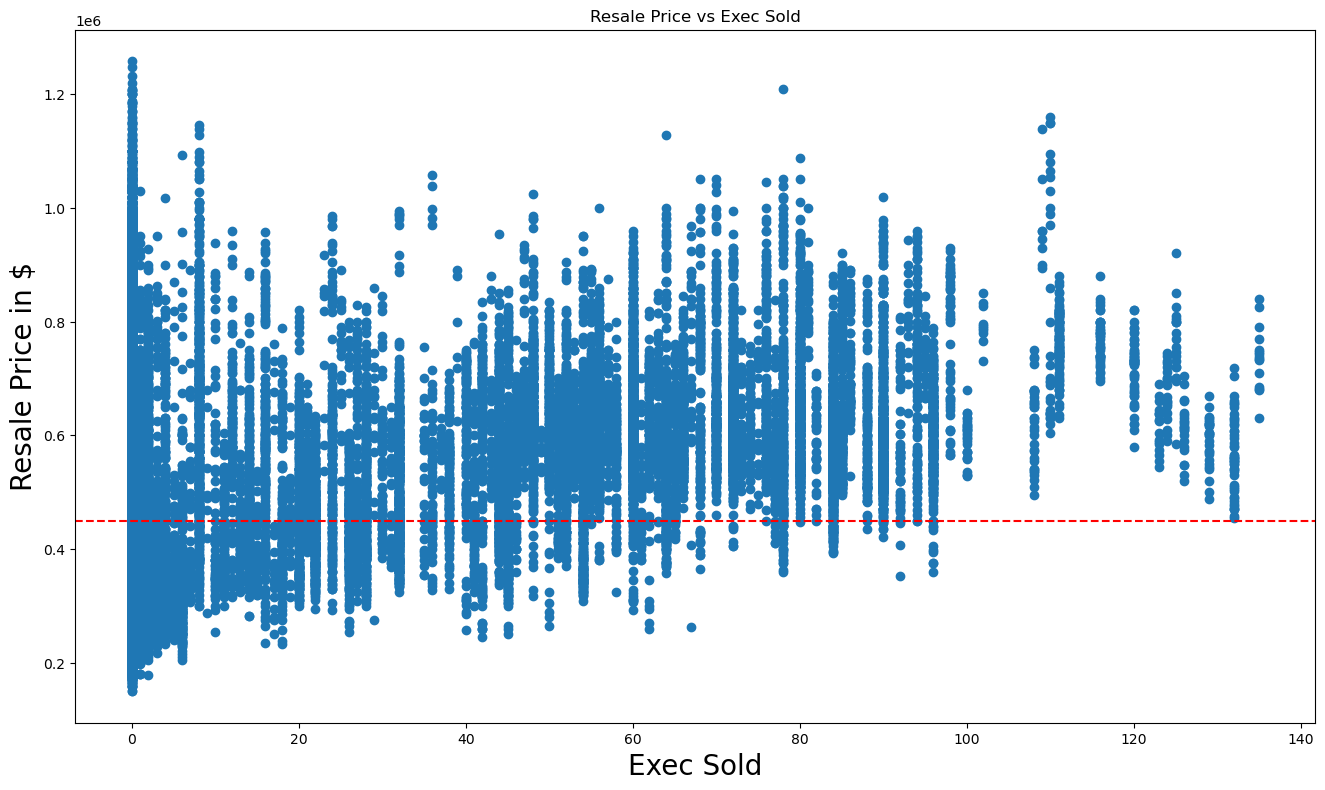

In [34]:
# Plot scatter plot of resale price vs exec sold
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['exec_sold'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs Exec Sold")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("Exec Sold", fontsize = 20);

This also although not as obvious, follows the 5 room sold category in which the more numbers of Exec units sold, the higher the proportion of observations in the block sell for above the mean resale price.

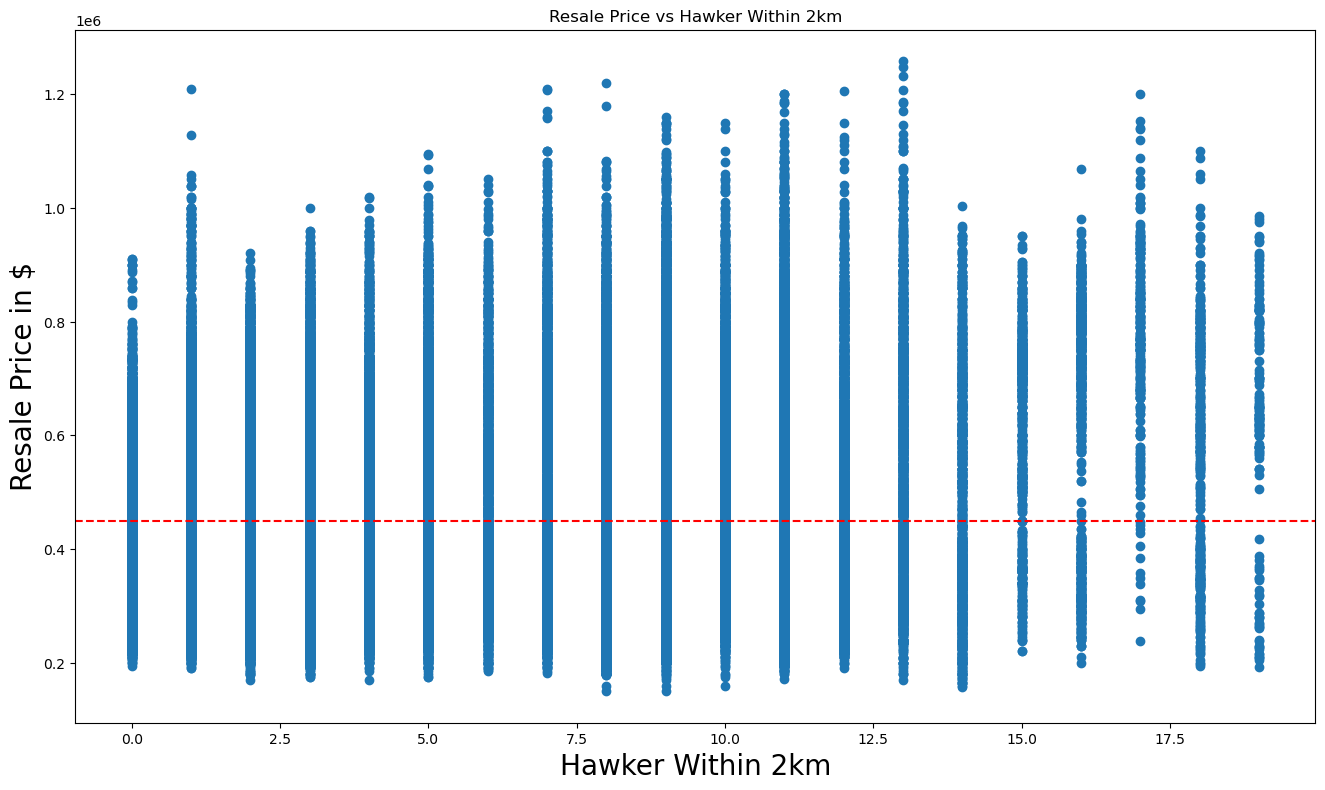

In [35]:
# Plot scatter plot of resale price vs hawker within 2km
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['hawker_within_2km'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs Hawker Within 2km")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("Hawker Within 2km", fontsize = 20);

This category is not so obvious in its correlation with resale price, although it can be observed that when the count goes above 15, there is a larger percentage of the observations that sold for above the mean resale price.

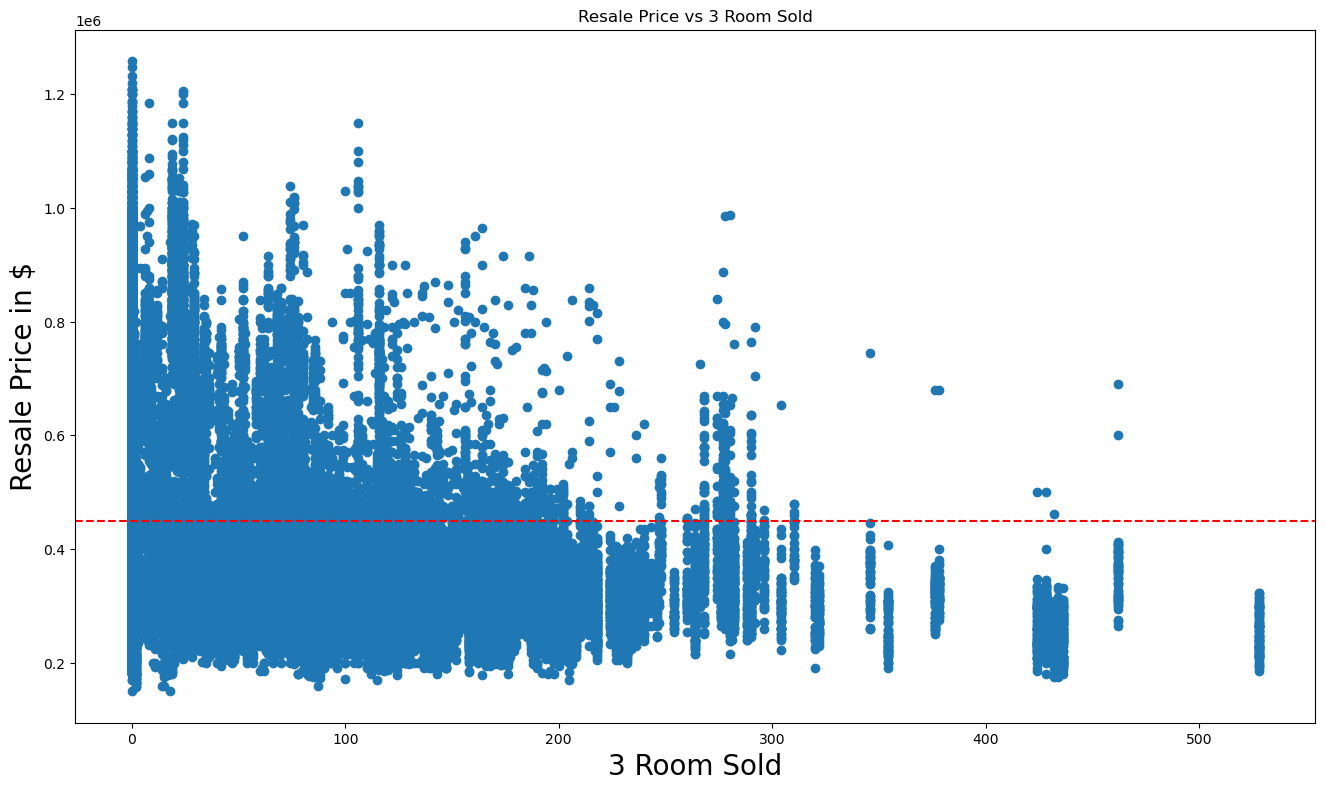

In [36]:
# Plot scatter plot of resale price vs 3 room sold
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['3room_sold'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs 3 Room Sold")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("3 Room Sold", fontsize = 20);

The 3 room sold feature exhibits a clearer negative correlation to the resale price. The higher the number of units sold, the more proportion of observations tend to fall below the mean.

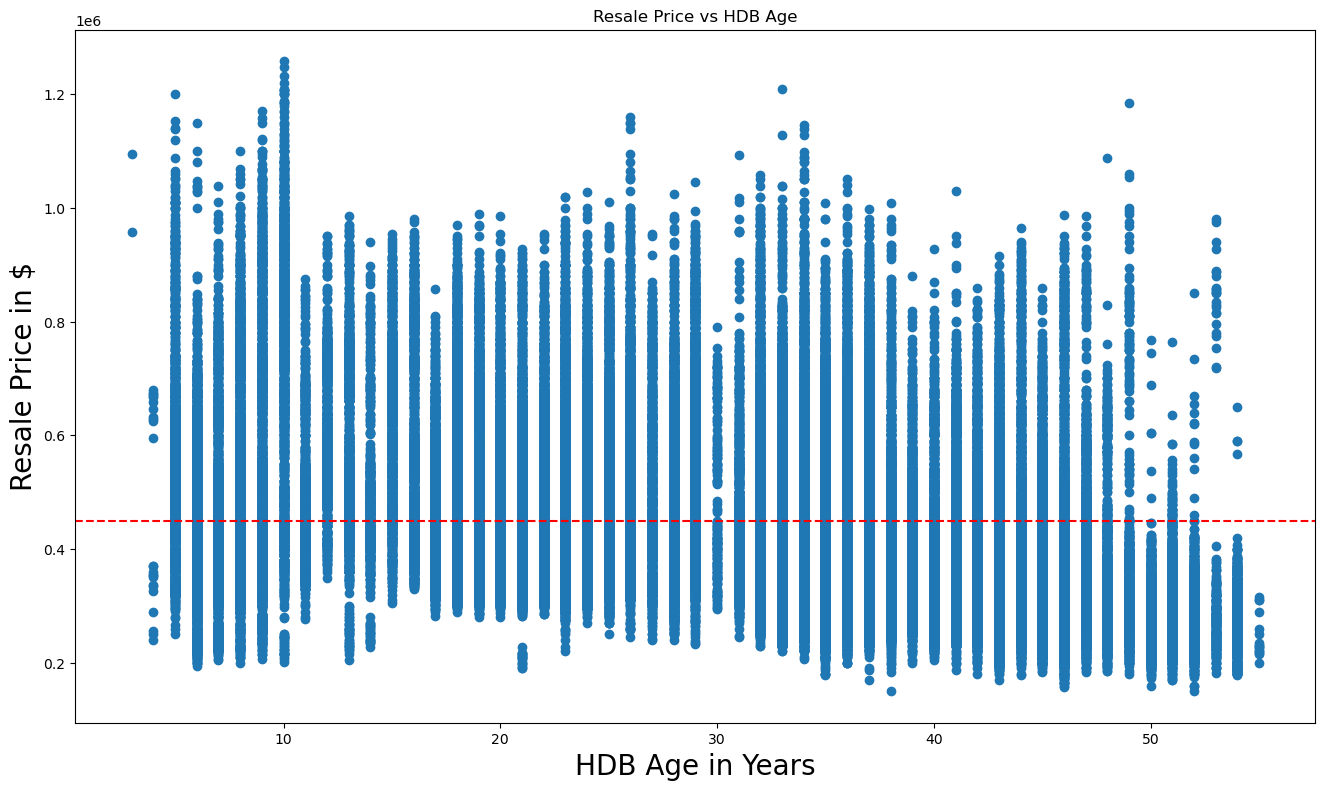

In [37]:
# Plot scatter plot of resale price vs HDB age
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['hdb_age'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs HDB Age")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("HDB Age in Years", fontsize = 20);

The hdb age also exhibits a clear negative correlation to the resale price where the older the flat, the higher percentage of observations fall below the mean resale price, although this isn't so clear in the first 25 years.

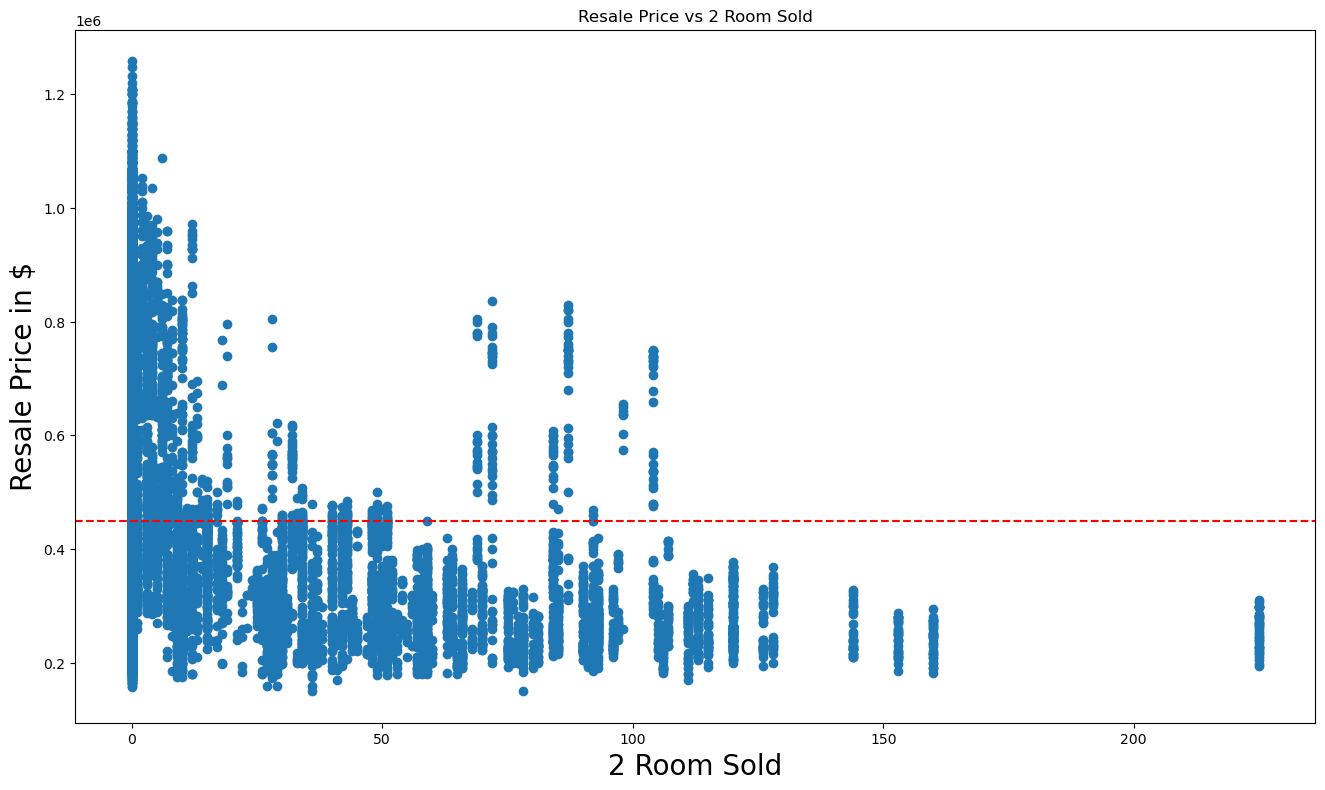

In [38]:
# Plot scatter plot of resale price vs 2 room sold
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['2room_sold'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs 2 Room Sold")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("2 Room Sold", fontsize = 20);

There is also a very clear negative correlation to resale price with 2 room units sold in the block. The lower the count, the higher the numbe of observations tend to fall above the mean resale price.

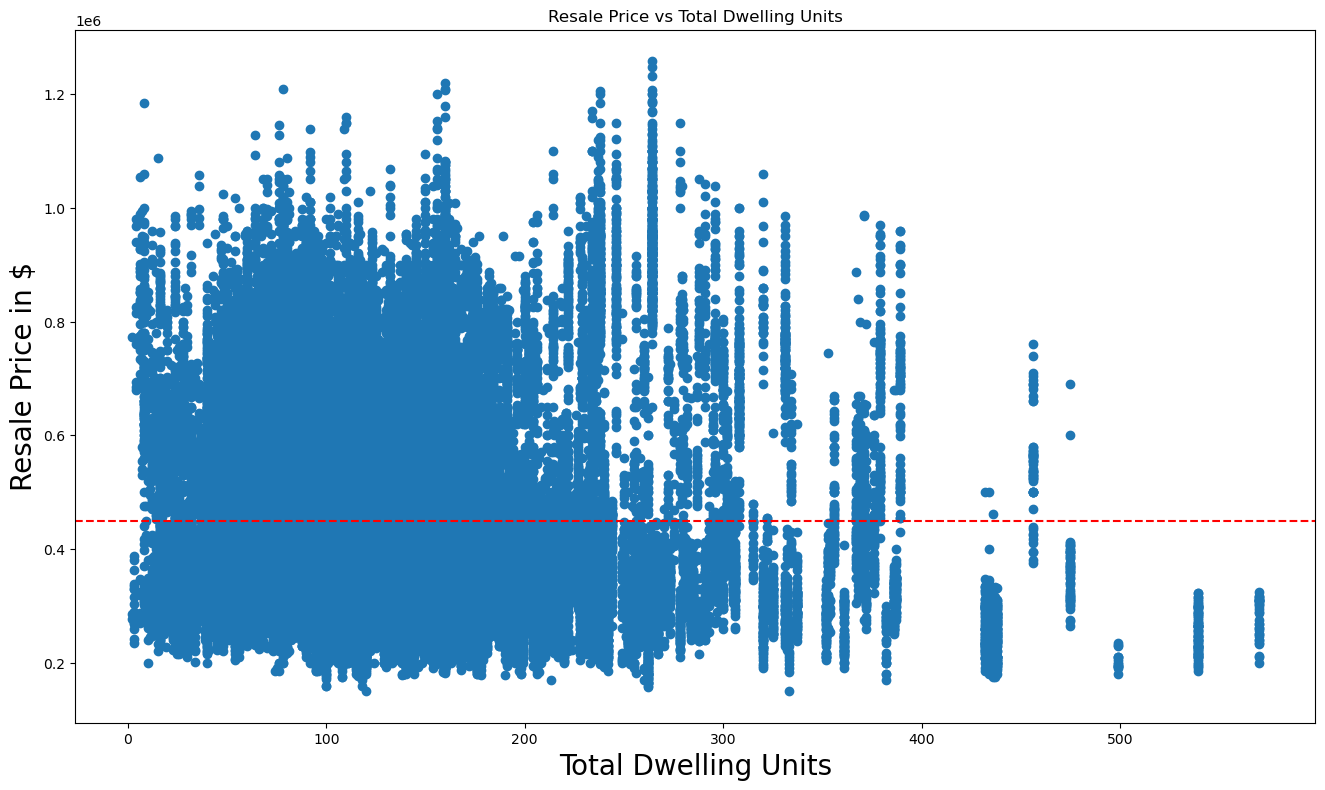

In [39]:
# Plot scatter plot of resale price vs total dwelling units
plt.figure(figsize = (16, 9))

plt.scatter(cont_features['total_dwelling_units'], #x-axis
            cont_features['resale_price']); #y-axis

plt.axhline(resale_mean, color='r', linestyle='--')
plt.title("Resale Price vs Total Dwelling Units")
plt.ylabel("Resale Price in $", fontsize = 20)
plt.xlabel("Total Dwelling Units", fontsize = 20);

The total dwelling units seems to indicate that the more densely populated a block is, the lower the resale price of the flat. higher counts in this category shows more observations sold below the mean resale price.

In [40]:
# Create new dataframe with the selected continuous features
cont_features_select = cont_features[['id', 'floor_area_sqm', 'max_floor_lvl', 
                                     '5room_sold', 'upper', 'exec_sold',
                                      'hawker_within_2km', '3room_sold',
                                      'hdb_age', '2room_sold', 'total_dwelling_units'
                                     ]].copy()

In [41]:
cont_features_select.head()

,id,floor_area_sqm,max_floor_lvl,5room_sold,upper,exec_sold,hawker_within_2km,3room_sold,hdb_age,2room_sold,total_dwelling_units
0,88471,90.0,25,46,12,0,13.0,0,15,0,142
1,122598,130.0,9,56,9,0,7.0,0,34,0,112
2,170897,144.0,16,30,15,60,1.0,0,24,0,90
3,86070,103.0,11,7,5,0,9.0,0,29,0,75
4,153632,83.0,4,18,3,0,1.0,0,34,0,48


I will now pick from the categorical features in order to add features to the model. I will initially use boxplots to determine if there are correlations between the feature and the resale price.

In [42]:
# Print the first 5 rows of the categorical features
cat_features.head()

,storey_range,flat_model,full_flat_type,address,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,planning_area,pri_sch_name,sec_sch_name,resale_price,id
0,10 TO 12,Model A,4 ROOM Model A,"3B, UPP BOON KENG RD",Y,N,N,N,N,Kallang,Geylang Methodist School,Geylang Methodist School,680000.0,88471
1,07 TO 09,Improved,5 ROOM Improved,"153, BISHAN ST 13",Y,N,N,N,N,Bishan,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian Secondary School,665000.0,122598
2,13 TO 15,Apartment,EXECUTIVE Apartment,"289B, BT BATOK ST 25",Y,N,N,N,N,Bukit Batok,Keming Primary School,Yusof Ishak Secondary School,838000.0,170897
3,01 TO 05,Model A,4 ROOM Model A,"232, BISHAN ST 22",Y,Y,N,N,N,Bishan,Catholic High School,Catholic High School,550000.0,86070
4,01 TO 03,Simplified,4 ROOM Simplified,"876, YISHUN ST 81",Y,N,N,N,N,Yishun,Naval Base Primary School,Orchid Park Secondary School,298000.0,153632


In [43]:
# Check for the number of features 
cat_features.shape

(149805, 14)

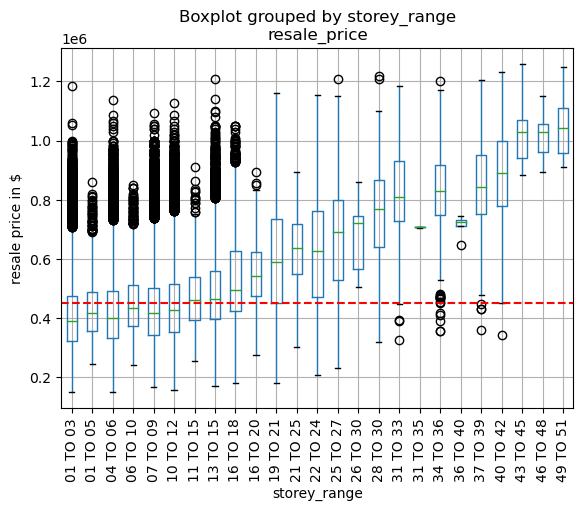

In [44]:
# Using box plots to determine correlations
cat_features.boxplot(column = 'resale_price', by = 'storey_range', rot = 90)

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

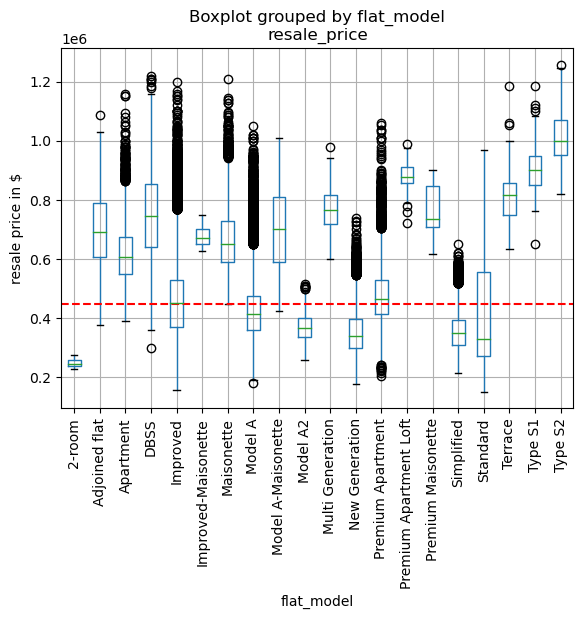

In [45]:
cat_features.boxplot(column = 'resale_price', by = 'flat_model', rot = 90)

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

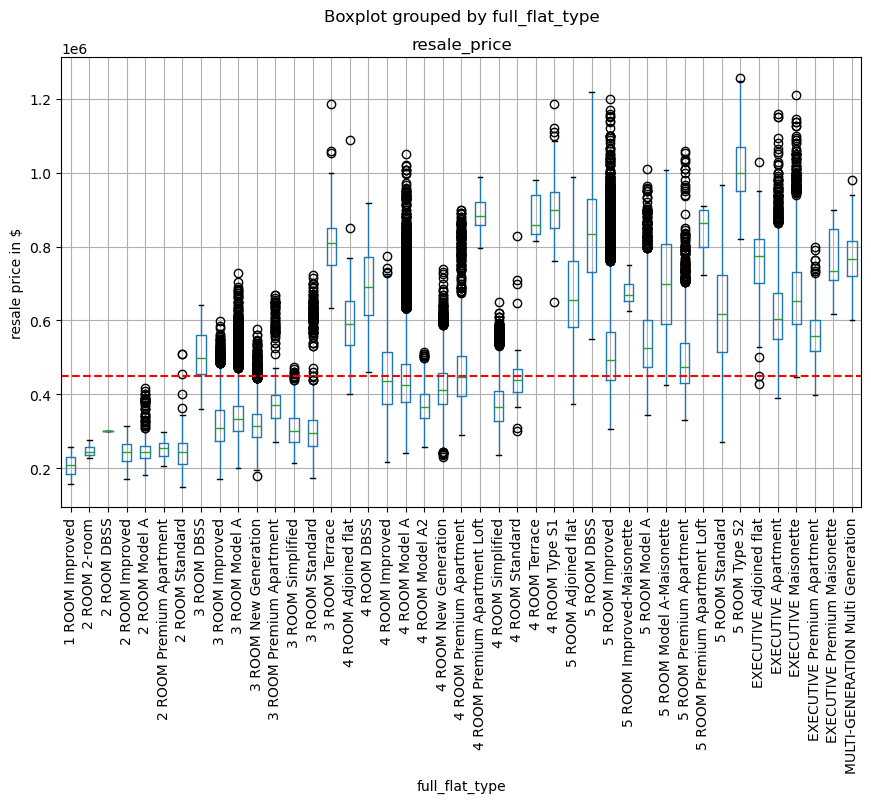

In [46]:
cat_features.boxplot(column = 'resale_price', by = 'full_flat_type', rot = 90, figsize=(10,6))

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

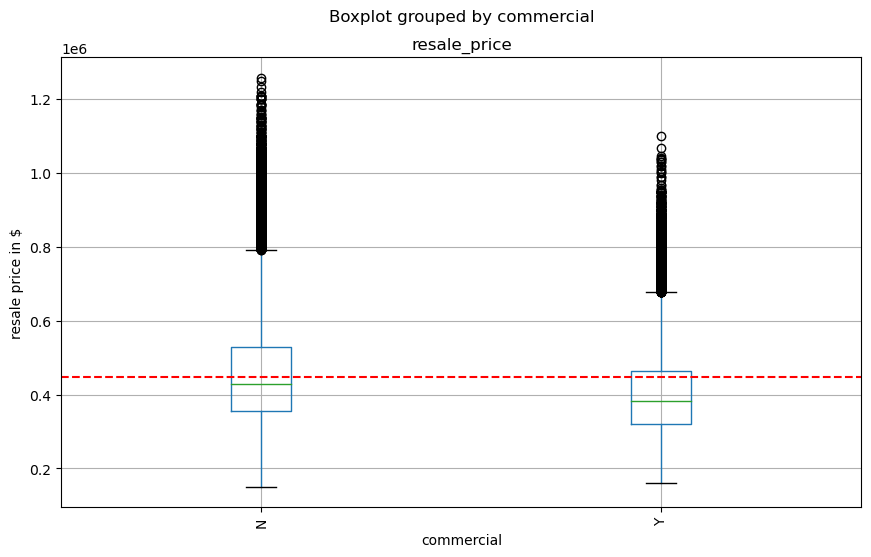

In [47]:
cat_features.boxplot(column = 'resale_price', by = 'commercial', rot = 90, figsize=(10,6))

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

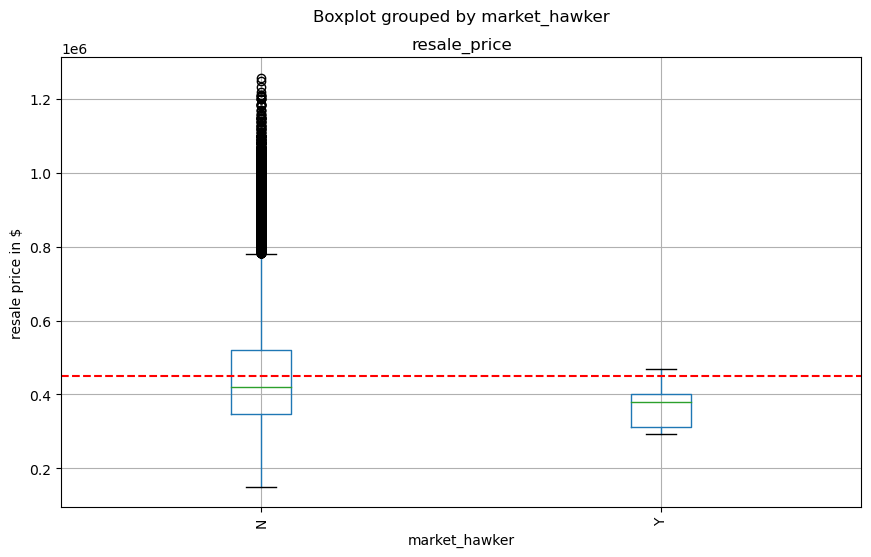

In [48]:
cat_features.boxplot(column = 'resale_price', by = 'market_hawker', rot = 90, figsize=(10,6))

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

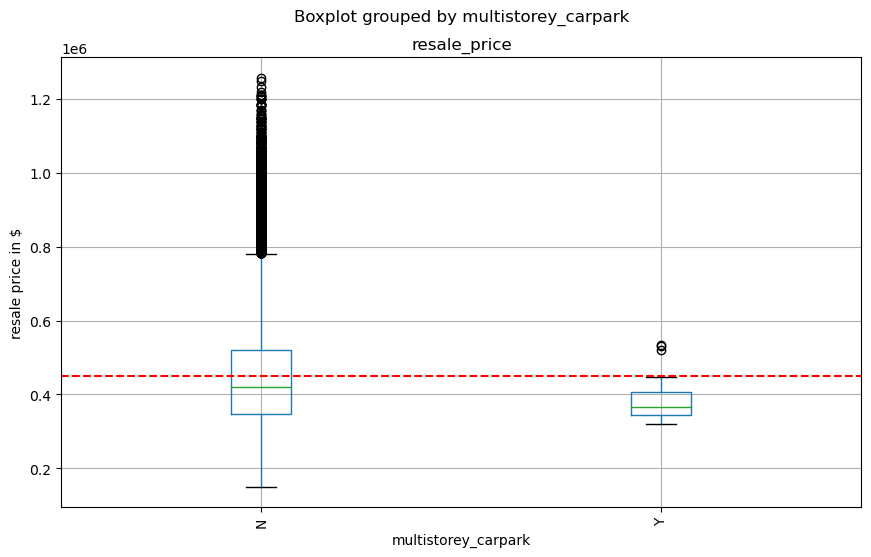

In [49]:
cat_features.boxplot(column = 'resale_price', by = 'multistorey_carpark', rot = 90, figsize=(10,6))

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

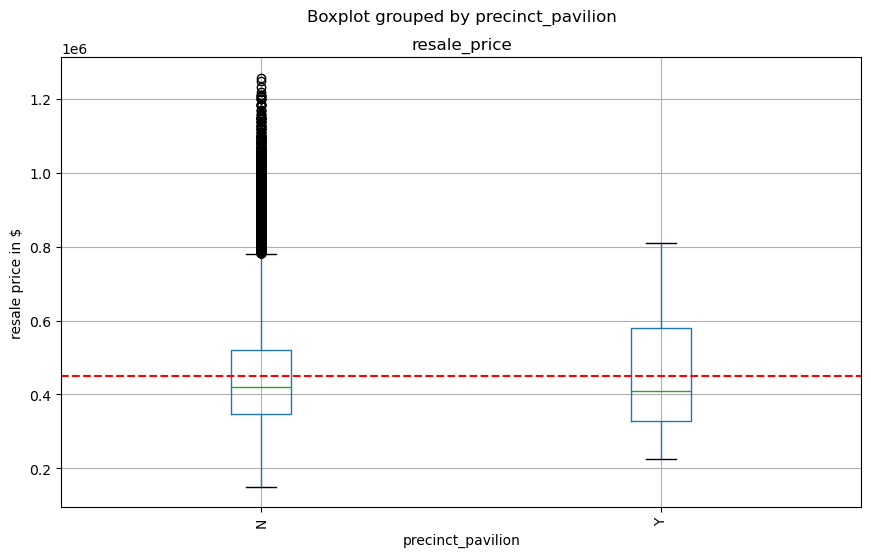

In [50]:
cat_features.boxplot(column = 'resale_price', by = 'precinct_pavilion', rot = 90, figsize=(10,6))

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

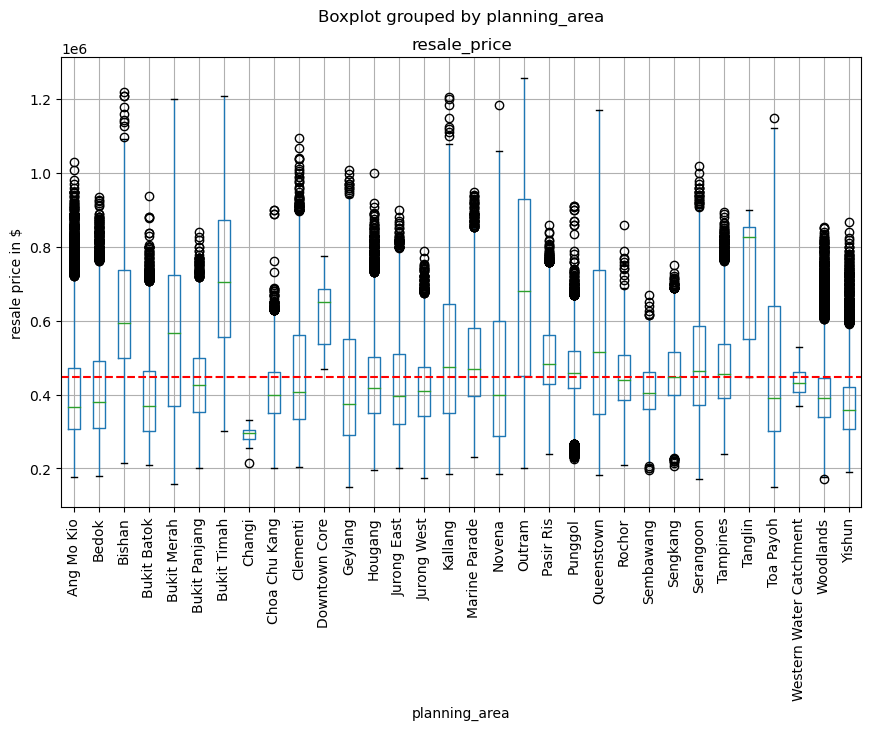

In [51]:
cat_features.boxplot(column = 'resale_price', by = 'planning_area', rot = 90, figsize=(10,6))

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

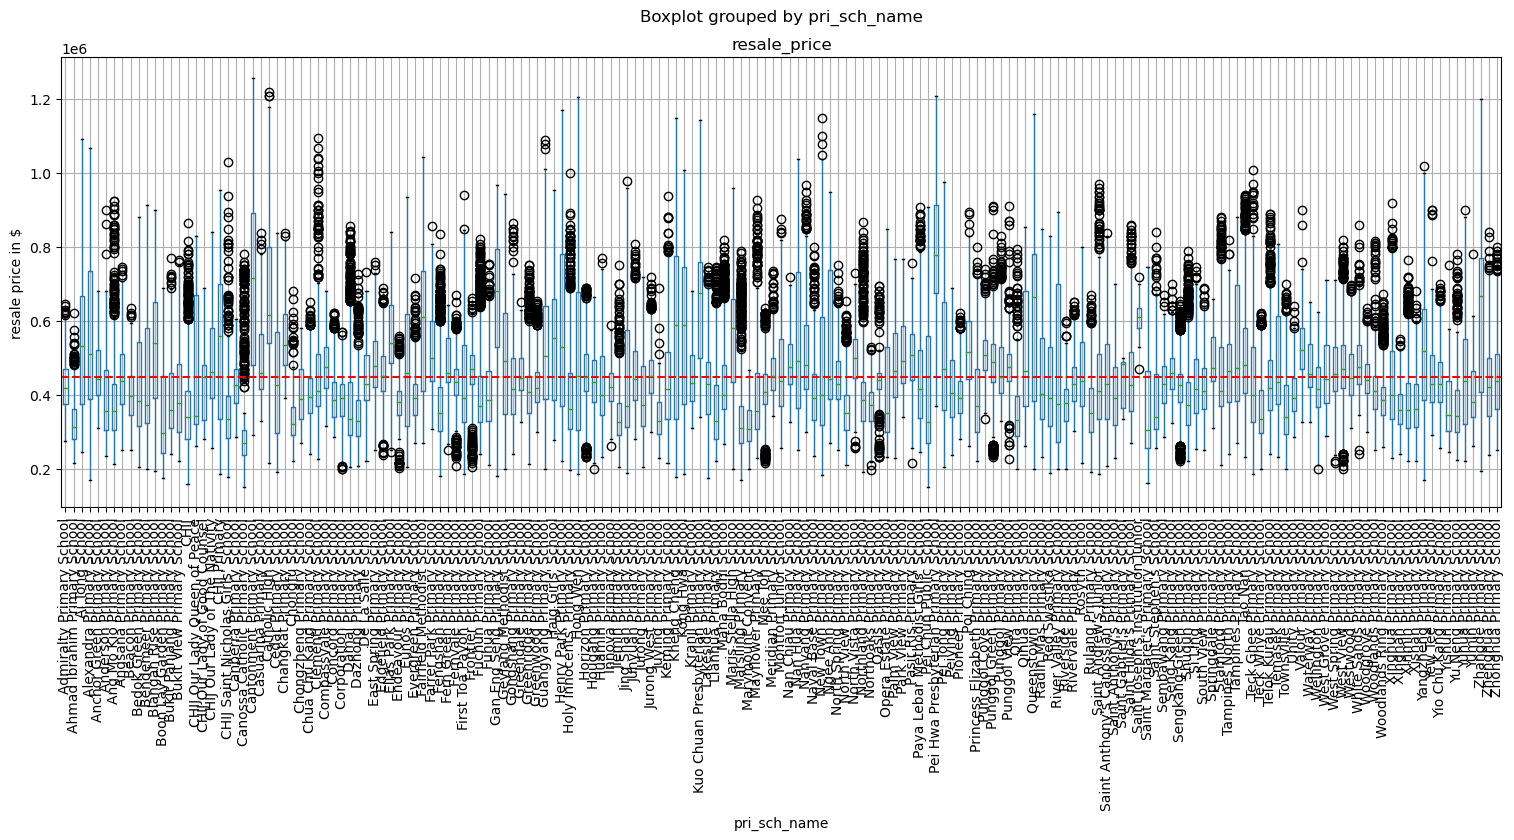

In [52]:
cat_features.boxplot(column = 'resale_price', by = 'pri_sch_name', rot = 90, figsize=(18,6))

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

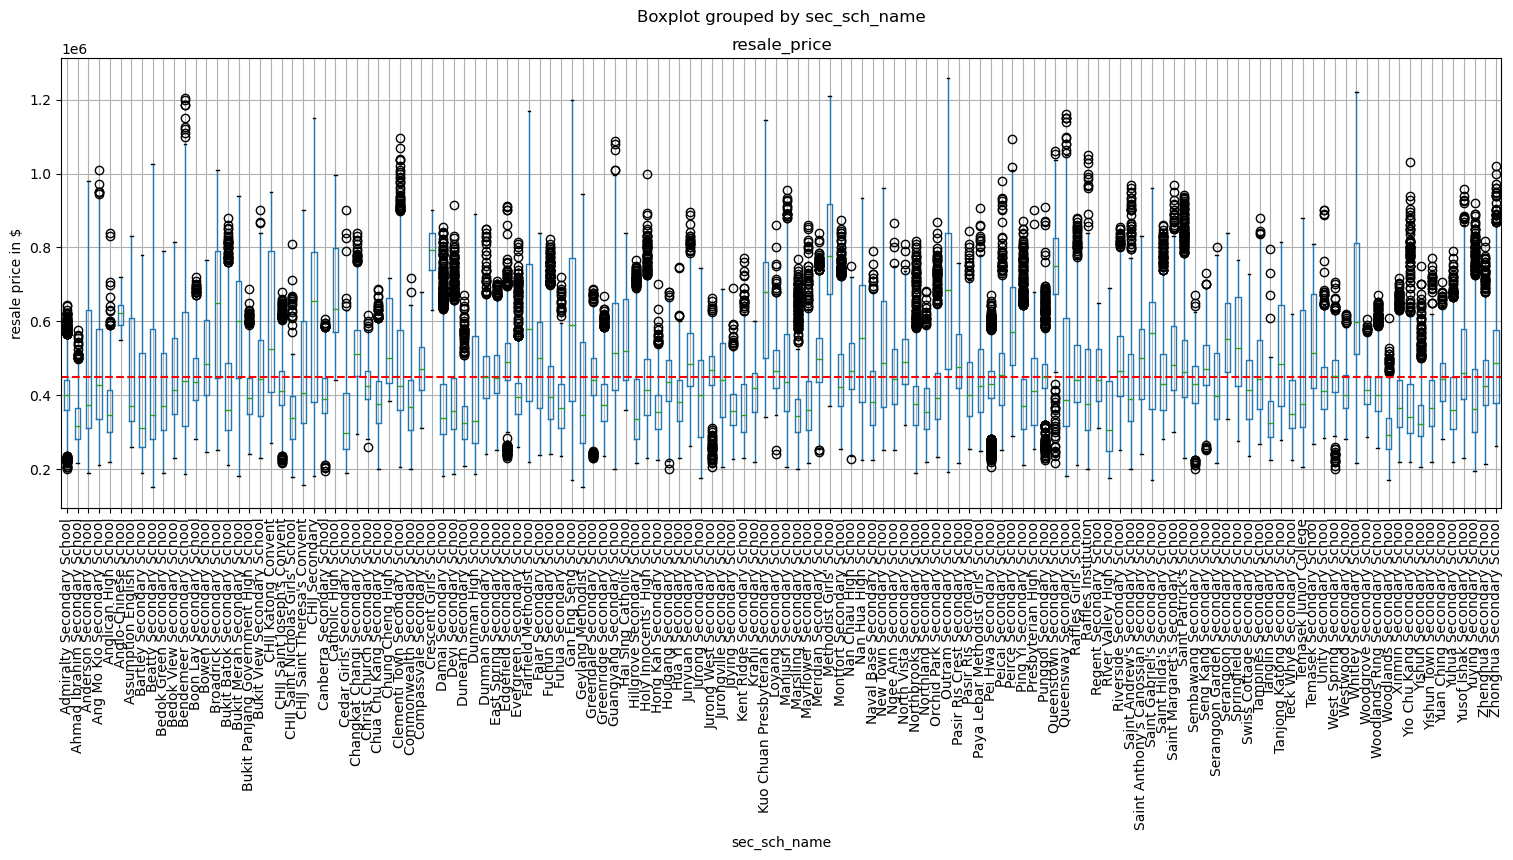

In [53]:
cat_features.boxplot(column = 'resale_price', by = 'sec_sch_name', rot = 90, figsize=(18,6))

plt.axhline(resale_mean, color='r', linestyle='--')
plt.ylabel('resale price in $');

Having observed the box plots, the features that I have picked for further analysis are storey_range and planning_area as they are simple enough to understand, and they do show some correlation to the resale price in terms of a clear change in price values across different categories.

### Preprocessing and Modelling

##### Baseline Model

Creating a baseline model with which to work with first using 3 continuous features.
1. floor_area_sqm
2. hdb_age
3. max_floor_lvl

In [54]:
# Set baseline X and y
baseline = ['floor_area_sqm', 'hdb_age', 'max_floor_lvl']
X_baseline = cont_features[baseline]
y_baseline = cont_features['resale_price']

In [55]:
# Train test split
X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = train_test_split(X_baseline, y_baseline, test_size = 0.2, random_state=42)

In [56]:
ss = StandardScaler()
X_baseline_train = ss.fit_transform(X_baseline_train)
X_baseline_test = ss.transform(X_baseline_test)

In [57]:
lr_baseline = LinearRegression()
lr_baseline.fit(X_baseline_train, y_baseline_train)
lr_baseline_scores = -cross_val_score(lr_baseline, X_baseline_train, y_baseline_train, scoring = 'neg_root_mean_squared_error')

lr_baseline_scores.mean()

86695.08638797168

Baseline cross val score of 86695 based on RMSE is the score that my models have to beat.

In [58]:
# Test scores
mean_squared_error(y_baseline_test, lr_baseline.predict(X_baseline_test)) ** 0.5

87400.66103173111

In [59]:
# Train score
mean_squared_error(y_baseline_train, lr_baseline.predict(X_baseline_train)) ** 0.5

86693.36088962096

There is some similarity in the test and cross val scores, but evidence of underfitting here is present.

In [60]:
cat_features.head()

,storey_range,flat_model,full_flat_type,address,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,planning_area,pri_sch_name,sec_sch_name,resale_price,id
0,10 TO 12,Model A,4 ROOM Model A,"3B, UPP BOON KENG RD",Y,N,N,N,N,Kallang,Geylang Methodist School,Geylang Methodist School,680000.0,88471
1,07 TO 09,Improved,5 ROOM Improved,"153, BISHAN ST 13",Y,N,N,N,N,Bishan,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian Secondary School,665000.0,122598
2,13 TO 15,Apartment,EXECUTIVE Apartment,"289B, BT BATOK ST 25",Y,N,N,N,N,Bukit Batok,Keming Primary School,Yusof Ishak Secondary School,838000.0,170897
3,01 TO 05,Model A,4 ROOM Model A,"232, BISHAN ST 22",Y,Y,N,N,N,Bishan,Catholic High School,Catholic High School,550000.0,86070
4,01 TO 03,Simplified,4 ROOM Simplified,"876, YISHUN ST 81",Y,N,N,N,N,Yishun,Naval Base Primary School,Orchid Park Secondary School,298000.0,153632


In [61]:
# create a new dataframe for selected categorical features
cat_features_select = cat_features[['id', 'storey_range', 'full_flat_type','planning_area', 'resale_price']].copy()

In [62]:
cat_features_select.head()

,id,storey_range,full_flat_type,planning_area,resale_price
0,88471,10 TO 12,4 ROOM Model A,Kallang,680000.0
1,122598,07 TO 09,5 ROOM Improved,Bishan,665000.0
2,170897,13 TO 15,EXECUTIVE Apartment,Bukit Batok,838000.0
3,86070,01 TO 05,4 ROOM Model A,Bishan,550000.0
4,153632,01 TO 03,4 ROOM Simplified,Yishun,298000.0


In [63]:
# Combine all selected features
features_select = cat_features_select.join(cont_features_select.set_index('id'), on='id')

In [64]:
features_select.head()

,id,storey_range,full_flat_type,planning_area,resale_price,floor_area_sqm,max_floor_lvl,5room_sold,upper,exec_sold,hawker_within_2km,3room_sold,hdb_age,2room_sold,total_dwelling_units
0,88471,10 TO 12,4 ROOM Model A,Kallang,680000.0,90.0,25,46,12,0,13.0,0,15,0,142
1,122598,07 TO 09,5 ROOM Improved,Bishan,665000.0,130.0,9,56,9,0,7.0,0,34,0,112
2,170897,13 TO 15,EXECUTIVE Apartment,Bukit Batok,838000.0,144.0,16,30,15,60,1.0,0,24,0,90
3,86070,01 TO 05,4 ROOM Model A,Bishan,550000.0,103.0,11,7,5,0,9.0,0,29,0,75
4,153632,01 TO 03,4 ROOM Simplified,Yishun,298000.0,83.0,4,18,3,0,1.0,0,34,0,48


In [65]:
features_select.shape

(149805, 15)

In [66]:
# Define X and y variables
X = features_select.drop(columns = ['id', 'resale_price'])
y = features_select['resale_price']

In [67]:
X.head()

,storey_range,full_flat_type,planning_area,floor_area_sqm,max_floor_lvl,5room_sold,upper,exec_sold,hawker_within_2km,3room_sold,hdb_age,2room_sold,total_dwelling_units
0,10 TO 12,4 ROOM Model A,Kallang,90.0,25,46,12,0,13.0,0,15,0,142
1,07 TO 09,5 ROOM Improved,Bishan,130.0,9,56,9,0,7.0,0,34,0,112
2,13 TO 15,EXECUTIVE Apartment,Bukit Batok,144.0,16,30,15,60,1.0,0,24,0,90
3,01 TO 05,4 ROOM Model A,Bishan,103.0,11,7,5,0,9.0,0,29,0,75
4,01 TO 03,4 ROOM Simplified,Yishun,83.0,4,18,3,0,1.0,0,34,0,48


In [68]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.2)

In [69]:
nominal = ['storey_range', 'full_flat_type', 'planning_area']

In [70]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train[nominal])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [71]:
X_train = ohe.transform(X_train[nominal])
X_test = ohe.transform(X_test[nominal])
column_name = ohe.get_feature_names_out(nominal)

In [72]:
# Scaling
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [73]:
# Instantiate LinearRegression
lr = LinearRegression()

In [74]:
lr.fit(X_train, y_train)

LinearRegression()

In [75]:
lr.score(X_train, y_train)

0.8200303451952575

In [76]:
lr.score(X_test, y_test)

0.8225167325806391

In [77]:
lr.predict(X_test)

array([663633.00501018, 343225.00501018, 591085.00501018, ...,
       370309.00501018, 199769.00501018, 913409.00501018])

In [105]:
lr_scores = -cross_val_score(lr, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=5)
lr_scores.mean()

956053492545266.6

Model CV score probably means that the model is over fitted. Next step to perform regularization on the model.

In [79]:
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [80]:
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]))

In [81]:
ridge.predict(X_test)

array([663642.55032606, 342831.66478584, 591110.41705578, ...,
       369866.83910834, 201520.89333563, 913196.24264229])

In [82]:
lasso.predict(X_test)

array([663121.48910936, 343212.72487466, 588203.26220163, ...,
       370508.50829502, 202133.21994543, 911383.24457914])

In [83]:
ridge.score(X_train, y_train)

0.8200472418314027

In [84]:
ridge.score(X_test, y_test)

0.822511884723684

In [85]:
lasso.score(X_train, y_train)

0.8200368497864263

In [86]:
lasso.score(X_test, y_test)

0.8224731891163755

In [106]:
ridge_scores = -cross_val_score(ridge, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=5)
ridge_scores.mean()

60715.915993762625

In [107]:
lasso_scores = -cross_val_score(lasso, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=5)
lasso_scores.mean()

60716.21463325342

After regularization, the RMSE scores performed better.

In [87]:
df_test = pd.read_csv('datasets/test.csv', low_memory = False)

In [88]:
df_test.columns = [c.replace(' ', '_') for c in df_test.columns]

In [89]:
df_test.columns = df_test.columns.str.lower()

In [90]:
df_test.head()

,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,...,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,...,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098
2,40303,2013-10,ANG MO KIO,3 ROOM,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,...,36,0,1.371893,103.851811,305.071191,Anderson Secondary School,245,0,1.374242,103.851430
3,109506,2017-10,WOODLANDS,4 ROOM,29,MARSILING DR,01 TO 03,97.0,New Generation,1979,...,54,0,1.434423,103.773698,433.454591,Woodlands Secondary School,188,0,1.439183,103.774499
4,100149,2016-08,BUKIT BATOK,4 ROOM,170,BT BATOK WEST AVE 8,16 TO 18,103.0,Model A,1985,...,40,0,1.349195,103.741000,217.295361,Bukit Batok Secondary School,223,0,1.348351,103.740873


In [91]:
df_test_id = df_test['id']

In [92]:
df_test = df_test[['floor_area_sqm', 'max_floor_lvl', '5room_sold', 'upper', 'exec_sold', 'hawker_within_2km', '3room_sold', 'hdb_age', '2room_sold', 'total_dwelling_units', 'storey_range', 'full_flat_type', 'planning_area']]

In [93]:
df_test = ohe.transform(df_test[nominal])

In [94]:
df_test = ss.transform(df_test)

In [95]:
df_test.shape

(16737, 100)

In [108]:
ridge.predict(X_test)

array([663642.55032606, 342831.66478584, 591110.41705578, ...,
       369866.83910834, 201520.89333563, 913196.24264229])

In [109]:
lr.predict(df_test)

array([340313.00501018, 465366.00501018, 345157.00501018, ...,
       433313.00501018, 517297.00501018, 399965.50501018])

In [110]:
ridge.predict(df_test)

array([340389.94030668, 465192.90697867, 346230.80912652, ...,
       432972.75143565, 517477.13653044, 399614.10654253])

In [111]:
lasso.predict(df_test)

array([340745.88784515, 464948.48624873, 346172.55774143, ...,
       433237.76407513, 517518.19692493, 399827.29903099])

In [113]:
df_submit = pd.DataFrame(ridge.predict(df_test), columns=['Predicted'])
df_submit = pd.concat([df_test_id, df_submit], axis = 1)
df_submit.columns = df_submit.columns.str.title()
df_submit.to_csv('datasets/test-score.csv', index=False)

Kaggle score = 60884

The model was able to predict on unseen data with a score of 60884 RMSE based on the selected features and regularized using ridgeCV.

### Conclusion

1. Original model was overfitted and the regularised ridge model had the best CV score.

2. The model that was created was based off main features that included, size of the property, location of the property, age of the property and some demand and supply factors. 

3. Model will be able to give a rough gauge of the required budgets for buyers, and also estimate to a certain degree the amount that a seller would be able to list the property for.

4. The model is simple enough to explain to clients based on features that are commonly thought factors in affecting property prices.

### Limitations

1. The model is based off past information and has to be continually retrained in order to be useful.

2. The model also does not take into account special circumstances like HDB cooling measures and interest rate hikes.

3. The model is not able to factor in wider demand and supply issues, like covid lockdown and the effect it had on the supply of new BTO flats which also caused an accross the board raise in HDB resale prices.

### Recommendations

1. Property agents should use this model to help estimate both buying and selling budgets for clients based off the main features highlighted above in the conclusions.

2. Agents will be able to help selling clients highlight which features should be marketed in order to get better resale prices.

3. It is recommended that in later models, information on demand and supply factors, interest rates and govt policy be added in.